In [1]:
from fastai.vision.all import *
from fastbook import *
from fastai import *

In [2]:
path = untar_data(URLs.CAMVID)
path.ls()

(#4) [Path('/storage/data/camvid/valid.txt'),Path('/storage/data/camvid/labels'),Path('/storage/data/camvid/images'),Path('/storage/data/camvid/codes.txt')]

In [3]:
path_lbl = path/'labels'
path_img = path/'images'

In [4]:
files = get_image_files(path_img)

In [5]:
files[:3]

(#3) [Path('/storage/data/camvid/images/Seq05VD_f02190.png'),Path('/storage/data/camvid/images/Seq05VD_f03420.png'),Path('/storage/data/camvid/images/Seq05VD_f01080.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

(#3) [Path('/storage/data/camvid/labels/0006R0_f01320_P.png'),Path('/storage/data/camvid/labels/0016E5_04950_P.png'),Path('/storage/data/camvid/labels/0016E5_05940_P.png')]

<AxesSubplot:>

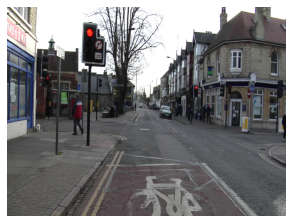

In [7]:
img_f = files[0]
img_f = Image.open(img_f)
show_image(img_f,figsize=(5,5))

In [8]:
get_y = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [11]:
get_y(files[0])

Path('/storage/data/camvid/labels/Seq05VD_f02190_P.png')

In [13]:
mask = OpenMask(get_y(files[0]))


<AxesSubplot:>

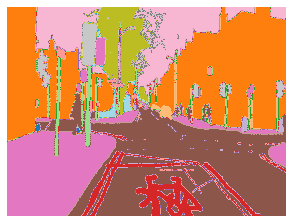

In [14]:
mask.show(figsize=(5,5), alpha=1)

In [15]:
tensor(mask)

tensor([[ 4,  4,  4,  ..., 21, 21, 21],
        [ 4,  4,  4,  ..., 21, 21, 21],
        [ 4,  4,  4,  ..., 21, 21, 21],
        ...,
        [19, 19, 19,  ..., 17, 17, 17],
        [19, 19, 19,  ..., 17, 17, 17],
        [19, 19, 19,  ..., 17, 17, 17]], dtype=torch.uint8)

In [16]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter',
       'OtherMoving', 'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone', 'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [17]:
def FileSplitter(fname):
    
    valid = Path(fname).read_text().split('\n') 
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner

In [18]:
sz = mask.shape; sz

(720, 960)

In [19]:
half = tuple(int(x/4) for x in sz); half

(180, 240)

In [20]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=FileSplitter(path/'valid.txt'),
                   get_y=get_y,
                   batch_tfms=[*aug_transforms(size=half), Normalize.from_stats(*imagenet_stats)])

In [22]:
dls = camvid.dataloaders(path/'images', bs=4)

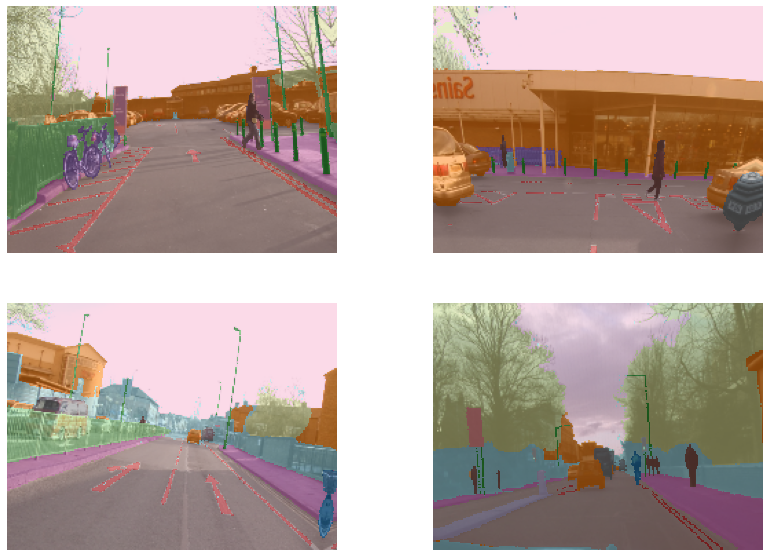

In [23]:
dls.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14,10))

In [24]:
dls.vocab = codes

In [25]:
name2id = {v:k for k,v in enumerate(codes)}

In [26]:
void = name2id['Void']

In [27]:
def acc_camvid(inp, targ):
  targ = targ.squeeze(1)
  mask = targ != void
  return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()


In [28]:
learn = unet_learner(dls, resnet34, metrics=acc_camvid, self_attention=True, act_cls=Mish, opt_func=ranger)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [29]:
learn.summary()

DynamicUnet (Input shape: 4 x 3 x 180 x 240)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 64 x 90 x 120   
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     4 x 64 x 45 x 60    
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

SuggestedLRs(valley=0.00015848931798245758)

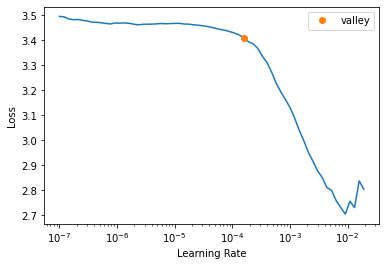

In [30]:
learn.lr_find()

In [31]:
lr = 1e-3

In [34]:
learn.fit_flat_cos(10, slice(lr))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.568708,0.548784,0.843093,01:15
1,0.529308,0.545240,0.845617,01:15
2,0.488326,0.411464,0.890353,01:14
3,0.455552,0.418051,0.881281,01:15
4,0.419155,0.386059,0.888850,01:15
5,0.394016,0.380533,0.896746,01:14
6,0.389208,0.366656,0.899502,01:14
7,0.370346,0.342700,0.909756,01:14
8,0.317312,0.341254,0.908842,01:14
9,0.275189,0.330669,0.912082,01:15


In [45]:
dl = learn.dls.test_dl(files[:4])

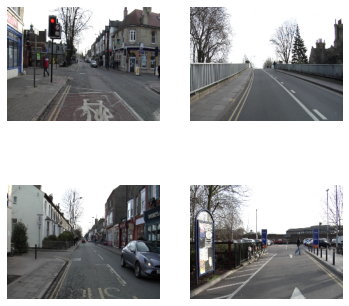

In [46]:
dl.show_batch()

In [47]:
preds = learn.get_preds(dl=dl)

In [48]:
pred_1 = preds[0][0]
pred_arx = pred_1.argmax(dim=0)

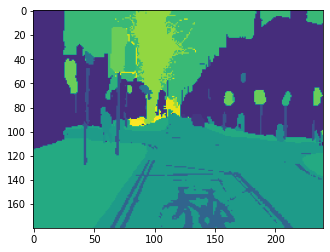

In [49]:
plt.imshow(pred_arx)